In [1]:
!pip install finance-datareader

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import random

num_images = 5000
day_num = 32

In [23]:
def convert_image(data, num_images, day_num, change_std, save = False, test = False):
    if test:
        change_std = 0

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha))),
            255,
        ]

    # 데이터수가 너무 적으면 패스
    if len(data) <= 100:
        return []


    # 해당 종목의 주가 데이터 - 100이 요구되는 이미지 수보다 적으면(상장직후는 변동이 심할 수있으니 제외)
    if num_images - 92 > len(data):
        num_images = len(data) - 92

    #return_datas는 이미지, 라벨링(상승이면1 하락이면0), 변동률, 날짜를 담고있음
    return_datas = []
    prediction_day_num = 5


    image_idx = 1
    while(image_idx <= num_images):
        prediction_day = data[-image_idx - prediction_day_num : -image_idx]
        predict_mean = prediction_day['Close'].mean()
        now = data.iloc[-image_idx - prediction_day_num - 1]
        change = (predict_mean - now['Close']) / now['Close']


        # change가 너무 높으면 이상치라고 판단하여 패스
        if not test and (abs(change) < change_std or change_std * 3 < abs(change)): # 향후 prediction_day_num일의 변동률이 기준 이하면
            image_idx += 1
            continue

        stock_data = data[-image_idx - day_num - prediction_day_num : -image_idx - prediction_day_num]

        # 이미지 크기 설정
        width, height = 96, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        close_prices = stock_data['Close'].values
        volume_data = stock_data['Volume'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        volume_data_norm = height * (volume_data) / (2 * (np.max(volume_data)))

        # 이동평균선 추가를 위한 stock_data 생성
        stock_data_ma20 = data[-image_idx - day_num - 20 - prediction_day_num: -image_idx - prediction_day_num]
        stock_data_ma20 = stock_data_ma20.copy()
        stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        stock_data_ma20.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma20['MA20_norm'] = (
                (stock_data_ma20['MA20'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        stock_data_ma40 = data[-image_idx - day_num - 40 - prediction_day_num: -image_idx - prediction_day_num]
        stock_data_ma40 = stock_data_ma40.copy()
        stock_data_ma40['MA40'] = stock_data_ma40['Close'].rolling(window=40).mean()
        stock_data_ma40.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma40['MA40_norm'] = (
                (stock_data_ma40['MA40'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        stock_data_ma60 = data[-image_idx - day_num - 60 - prediction_day_num: -image_idx - prediction_day_num]
        stock_data_ma60 = stock_data_ma60.copy()
        stock_data_ma60['MA60'] = stock_data_ma60['Close'].rolling(window=60).mean()
        stock_data_ma60.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma60['MA60_norm'] = (
                (stock_data_ma60['MA60'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        # 96x96 이미지 생성
        img = np.zeros((height, width, 4), dtype=np.uint8)  # 4 channels for RGBA

        fail_generate = False
        for day in range(32):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(
                (
                    (stock_data['Open'].values[day] - np.min(low_prices))
                    / (np.max(high_prices) - np.min(low_prices))
                )
                * (height - 1)
            )
            volume = int(volume_data_norm[day])
            if(volume == 0):
                fail_generate = True
                break

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0, 255]  # 상승: 빨강
                    tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0, 255]  # 상승: 빨강
                        tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 255 and img[height - 1 - y, x][2] != 255:
                        img[height - 1 - y, x] = tail_color

            # 거래량 그리기
            for x in range(x_start, x_start + 3):
                overlapped = height - volume
                if overlapped >= 0 and overlapped < height:
                    img[overlapped:, x] = [
                        alpha_blend(img[y, x], [128, 128, 128, 255], 0.45)
                        for y in range(overlapped, height)
                    ]

            # 20일 이동평균선 그리기
            ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma20_norm):
                    ma20_y = int(ma20_norm * (height - 1))
                    if 0 <= ma20_y < height:
                        for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([255, 255, 0, 255], img[height - 1 - y, x], 0.6)  # 노란색으로 변경
                                img[height - 1 - y, x] = new_color

            # 40일 이동평균선 그리기
            ma40_norm = stock_data_ma40.iloc[day]['MA40_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma40_norm):
                    ma40_y = int(ma40_norm * (height - 1))
                    if 0 <= ma40_y < height:
                        for y in range(ma40_y - 1, ma40_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([128, 0, 128, 255], img[height - 1 - y, x], 0.6)  # 보라색으로 변경
                                img[height - 1 - y, x] = new_color

            # 60일 이동평균선 그리기
            ma60_norm = stock_data_ma60.iloc[day]['MA60_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma60_norm):
                    ma60_y = int(ma60_norm * (height - 1))
                    if 0 <= ma60_y < height:
                        for y in range(ma60_y - 1, ma60_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([0, 255, 0, 255], img[height - 1 - y, x], 0.6)  # 초록색으로 변경
                                img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += prediction_day_num
            continue

        if save :
            # 이미지 저장
            img = Image.fromarray(img, 'RGBA')
            img.save(f'stock_data_image_{image_idx}.png')

        if change_std <= change:
            return_datas.append((img, 1))
        elif change < -change_std :
            return_datas.append((img, 0))

            # 테스트는 촘촘하게 모든 데이터로
        if test:
            image_idx += random.choice(range(1, 6))
        else:
            # 비슷한 이미지를 피하기 위해 기준 예측일만큼 건너뜀
            image_idx += random.choice(range(1, 10))


    return return_datas

In [5]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [30]:
stock_codes2 = [
    ["005930", "삼성전자"],
    ["051910", "LG화학"],
    ["000660", "SK하이닉스"],
    ["207940", "삼성바이오로직스"],
    ["005935", "삼성전자우"],
    ["051915", "LG화학우"],
    ["006400", "삼성SDI"],
    ["005380", "현대차"],
    ["363280", "효성화학"],
    ["247540", "에코프로비엠"],
    ["000270", "기아"],
    ["086520", "에코프로"],
    ["035720", "카카오"],
    ["068270", "셀트리온"],
    ["012330", "현대모비스"],
    ["105560", "KB금융"],
    ["028260", "삼성물산"],
    ["055550", "신한지주"],
    ["096770", "SK이노베이션"],
    ["066570", "LG전자"],
    ["047050", "대우조선해양"],
    ["032830", "삼성생명"],
    ["323410", "카카오뱅크"],
    ["003550", "LG"],
    ["015760", "한국전력"],
    ["000810", "삼성화재"],
    ["033780", "KT&G"],
    ["091990", "셀트리온헬스케어"],
    ["009150", "삼성전기"],
    ["086790", "하나금융지주"],
    ["034730", "SK"],
    ["336370", "솔루스첨단소재"],
    ["352820", "하이브"],
    ["018260", "삼성에스디에스"],
    ["122630", "KODEX 레버리지"],
    ["017670", "SK텔레콤"],
    ["010130", "고려아연"],
    ["024880", "케이씨케미칼"],
    ["003490", "대한항공"],
    ["010950", "S-Oil"],
    ["086280", "현대글로비스"],
    ["259960", "크래프톤"],
    ["024110", "기업은행"],
    ["030200", "케이티"],
    ["316140", "우리금융지주"],
    ["010140", "삼성중공업"],
    ["090430", "아모레퍼시픽"],
    ["051900", "LG생활건강"],
    ["028050", "삼성엔지니어링"],
    ["233740", "KODEX 코스닥 150 레버리지"],
    ["011170", "롯데케미칼"],
    ["000100", "유한양행"],
    ["012450", "한화에어로스페이스"],
    ["036570", "엔씨소프트"],
    ["241560", "두산밥캣"],
    ["005830", "DB손해보험"],
    ["018880", "한온시스템"],
    ["034220", "LG디스플레이"],
    ["170030", "HD현대"],
    ["088980", "맥쿼리인프라"],
    ["005070", "코스모신소재"],
    ["271560", "오리온"],
    ["004020", "현대제철"],
    ["097950", "CJ제일제당"],
    ["047810", "한국항공우주"],
    ["042700", "한미반도체"],
    ["032640", "LG유플러스"],
    ["307950", "현대오토에버"],
    ["006800", "미래에셋증권"],
    ["007700", "F&F홀딩스"],
    ["251270", "넷마블"],
    ["128940", "한미약품"],
    ["000720", "현대건설"],
    ["010620", "현대미포조선"],
    ["006260", "LS"],
    ["078930", "GS"],
    ["011780", "금호석유"],
    ["035250", "강원랜드"],
    ["008770", "호텔신라"],
    ["005940", "NH투자증권"],
    ["180640", "한진칼"],
    ["016360", "삼성증권"],
    ["064350", "현대로템"],
    ["021240", "코웨이"],
    ["282330", "BGF리테일"],
    ["112610", "씨에스윈드"],
    ["071050", "한국금융지주"],
    ["002790", "아모레G"],
    ["008930", "한미사이언스"],
    ["004990", "롯데지주"],
    ["010780", "쌍용C&E"],
    ["001450",  "현대해상"],
    ["111770",  "영원무역"],
    ["272210",  "한화시스템"],
    ["052690",  "한전기술"],
    ["267260",  "HD현대일렉트릭"],
    ["007070",  "GS리테일"],
    ["028670",  "팬오션"],
    ["139480",  "이마트"],
    ["035900", "JYP Ent."], # 여기서부터는 코스닥
    ["263750", "펄어비스"],
    ["293490", "카카오게임즈"],
    ["196170", "알테오젠"],
    ["058470", "리노공업"],
    ["214150", "클래시스"],
    ["039030", "이오테크닉스"],
    ["278280", "천보"],
    ["137400", "피엔티"],
    ["237690", "에스티팜"],
    ["214450", "파마리서치"],
    ["240810", "원익IPS"],
    ["145020", "휴젤"],
    ["035760", "CJ ENM"],
    ["056190", "에스에프에이"],
    ["036930", "주성엔지니어링"],
    ["064760", "티씨케이"],
    ["213420", "덕산네오룩스"],
    ["195940", "HK이노엔"],
    ["014130", "레고켐바이오"],
    ["098460", "고영"],
    ["067310", "하나마이크론"],
    ["166090", "하나머티리얼즈"],
    ["348210", "넥스틴"],
    ["003380", "하림지주"],
    ["272290", "이녹스첨단소재"],
    ["085660", "차바이오텍"],
    ["074610", "원익QnC"],
    ["083470", "유진테크"],
    ["046890", "서울반도체"],
    ["086450", "동국제약"],
    ["215000", "골프존"],
    ["215200", "메가스터디교육"],
    ["319660", "피에스케이"],
    ["183300", "코미코"],
    ["200130", "콜마비앤에이치"],
    ["069080", "웹젠"],
    ["036830", "솔브레인홀딩스"],
    ["084850", "아이티엠반도체"],
    ["243070", "휴온스"],
    ["049070", "인탑스"],
    ["131290", "티에스이"],
    ["091700", "파트론"],
    ["064550", "바이오니아"],
    ["019550", "SFA반도체"],
    ["095610", "테스"],
    ["230360", "에코마케팅"],
    ["267980", "매일유업"],
    ['205470', '휴마시스'],
    ['060150', '인선이엔티'],
    ['417010', '나노팀'],
    ['036620', '감성코퍼레이션'],
    ['047920', 'HLB제약'],
    ['243840', '신흥에스이씨'],
    ['217270', '넵튠'],
    ['056080', '유진로봇'],
    ['018290', '브이티'],
    ['108490', '로보티즈'],
    ['059090', '미코'],
    ['348340', '뉴로메카'],
    ['041830', '인바디'],
    ['101360', '에코앤드림'],
    ['013030', '하이록코리아'],
    ['038500', '삼표시멘트'],
    ['307750', '국전약품'],
    ['049950', '미래컴퍼니'],
    ['092040', '아미코젠'],
    ['382840', '원준'],
    ['094360', '칩스앤미디어'],
    ['290670', '대보마그네틱'],
    ['029960', '코엔텍'],
    ['058820', 'CMG제약'],
    ['314930', '바이오다인'],
    ['047310', '파워로직스'],
    ['297090', '씨에스베어링'],
    ['104830', '원익머트리얼즈'],
    ['282880', '코윈테크'],
    ['077360', '덕산하이메탈'],
    ['214610', '미코바이오메드'],
    ['297890', 'HB솔루션'],
    ['122640', '예스티'],
    ['054210', '이랜텍'],
    ['285490', '노바텍'],
    ['025770', '한국정보통신'],
    ['089010', '켐트로닉스'],
    ['053030', '바이넥스'],
    ['030520', '한글과컴퓨터'],
    ['060370', 'KT서브마린'],
    ['126340', '비나텍'],
    ['254490', '미래반도체'],
    ['235980', '메드팩토'],
    ['102940', '코오롱생명과학'],
    ['101730', '위메이드맥스'],
    ['093320', '케이아이엔엑스'],
    ['251970', '펌텍코리아'],
    ['005160', '동국산업'],
    ['051500', 'CJ프레시웨이'],
    ['005090', 'SGC에너지'],
    ['232140', '와이아이케이'],
    ['000210', 'DL'],
    ['053210', '스카이라이프'],
]
print(len(stock_codes2))

def check_duplicate_stock_codes(stock_codes2):
    stock_codes_set = set()

    for code, name in stock_codes2:
        if code in stock_codes_set:
            print(f"중복된 종목코드 발견: {code} ({name})")
        else:
            stock_codes_set.add(code)

    if len(stock_codes_set) == len(stock_codes2):
        print("중복된 종목코드가 없습니다.")

# 종목코드 중복 여부 확인
check_duplicate_stock_codes(stock_codes2)

200
중복된 종목코드가 없습니다.


In [33]:
# 엑셀 파일 읽기
df = pd.read_csv('drive/MyDrive/Colab Notebooks/kosdaq.csv', usecols=[0, 1], dtype={1: str})
df = df[~df.iloc[:, 0].str.contains("스팩")]
df = df.iloc[:, [1, 0]]
df = df.sample(n=500, random_state=42)
# 첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

[['068760', '셀트리온제약'], ['317870', '엔바이오니아'], ['037950', '엘컴텍'], ['032190', '다우데이타'], ['200780', '비씨월드제약'], ['023460', 'CNH'], ['208350', '지란지교시큐리티'], ['294630', '서남'], ['166090', '하나머티리얼즈'], ['417840', '저스템'], ['016790', '카나리아바이오'], ['040350', '큐로컴'], ['310200', '애니플러스'], ['080010', '이상네트웍스'], ['066910', '손오공'], ['317240', 'TS트릴리온'], ['228760', '지노믹트리'], ['200470', '에이팩트'], ['424980', '마이크로투나노'], ['318160', '셀바이오휴먼텍'], ['006140', '피제이전자'], ['204020', '그리티'], ['252500', '세화피앤씨'], ['196300', '애니젠'], ['239610', '에이치엘사이언스'], ['115960', '연우'], ['078860', '아이오케이'], ['253590', '네오셈'], ['187790', '나노'], ['142760', '비엘'], ['425420', '티에프이'], ['032820', '우리기술'], ['192440', '슈피겐코리아'], ['064290', '인텍플러스'], ['054050', '농우바이오'], ['038060', '루멘스'], ['104200', 'NHN벅스'], ['900280', '골든센츄리'], ['067160', '아프리카TV'], ['434480', '모니터랩'], ['068330', '일신바이오'], ['309960', 'LB인베스트먼트'], ['206640', '바디텍메드'], ['190650', '코리아에셋투자증권'], ['102120', '어보브반도체'], ['211270', 'AP위성'], ['131220', '대한과학'], ['174900', '앱클론'], 

In [34]:
train_result = []
stock_codes += stock_codes2[:90]
print(len)
for i, ticker in enumerate(stock_codes):
    code, name = ticker[0], ticker[1]
    print(f"{i+1}번째 종목 {name} 추출중...   ")

    try:
        cnt = 0
        data = preprocess_data(fdr.DataReader(code, '2013-09-01', '2020-02-15'))  # 각 종목의 데이터 가져오기
        images = convert_image(data, 3000, day_num, 0.07)
        train_result += images
        cnt += len(images)
        data = preprocess_data(fdr.DataReader(code, '2020-03-01', '2022-12-31'))  # 각 종목의 데이터 가져오기
        images = convert_image(data, 1000, day_num, 0.07)
        train_result += images
        cnt += len(images)
        print(f"{cnt}개 추출완료. 누적{len(train_result)}개")
    except IndexError:
        print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
        continue

<built-in function len>
1번째 종목 셀트리온제약 추출중...   
셀트리온제약에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.
2번째 종목 엔바이오니아 추출중...   
17개 추출완료. 누적56개
3번째 종목 엘컴텍 추출중...   
43개 추출완료. 누적99개
4번째 종목 다우데이타 추출중...   
다우데이타에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.
5번째 종목 비씨월드제약 추출중...   
49개 추출완료. 누적184개
6번째 종목 CNH 추출중...   
32개 추출완료. 누적216개
7번째 종목 지란지교시큐리티 추출중...   
32개 추출완료. 누적248개
8번째 종목 서남 추출중...   
11개 추출완료. 누적259개
9번째 종목 하나머티리얼즈 추출중...   
하나머티리얼즈에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.
10번째 종목 저스템 추출중...   
0개 추출완료. 누적304개
11번째 종목 카나리아바이오 추출중...   
24개 추출완료. 누적328개
12번째 종목 큐로컴 추출중...   
큐로컴에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.
13번째 종목 애니플러스 추출중...   
15개 추출완료. 누적433개
14번째 종목 이상네트웍스 추출중...   
42개 추출완료. 누적475개
15번째 종목 손오공 추출중...   
60개 추출완료. 누적535개
16번째 종목 TS트릴리온 추출중...   
9개 추출완료. 누적544개
17번째 종목 지노믹트리 추출중...   
46개 추출완료. 누적590개
18번째 종목 에이팩트 추출중...   
76개 추출완료. 누적666개
19번째 종목 마이크로투나노 추출중...   
0개 추출완료. 누적666개
20번째 종목 셀바이오휴먼텍 추출중...   
0개 추출완료. 누적666개
21번째 종목 피제이전자 추출중...   
32개 추출완료. 누적698개
22번째 종목 그리티 추출중...   
2

In [35]:
print(len(train_result))
print(sum([low[1] for low in train_result]))

23832
13942


In [36]:
def get_same_labelnum(result, num):

    # 라벨별로 이미지 데이터 분리
    label0_images = [image_data for image_data, label in result if label == 0]
    label1_images = [image_data for image_data, label in result if label == 1]

    # 각 라벨에서 랜덤하게 5,000개씩 뽑기
    random_label0_images = random.sample(label0_images, num)
    random_label1_images = random.sample(label1_images, num)

    # 뽑은 이미지 데이터와 라벨을 다시 묶기
    new_label0_result = [(image_data, 0) for image_data in random_label0_images]
    new_label1_result = [(image_data, 1) for image_data in random_label1_images]

    # 두 결과를 번갈아가면서 합치기
    result = [t for pair in zip(new_label0_result, new_label1_result) for t in pair]
    return result

In [37]:
train_result = get_same_labelnum(train_result, 5000)
train_images, train_labels = zip(*train_result)
print(sum(train_labels))
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)

5000


In [ ]:
test_result = get_same_labelnum(test_result, 1250)
test_images, test_labels = zip(*test_result)
print(sum(test_labels))
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)

1250


In [38]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
# test_images = np.load('test_images.npy')
# test_labels = np.load('test_labels.npy')

train_images = train_images[:, :, :, :3]
# test_images = test_images[:, :, :, :3]

np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)
# np.save('test_images.npy', test_images)
# np.save('test_labels.npy', test_labels)

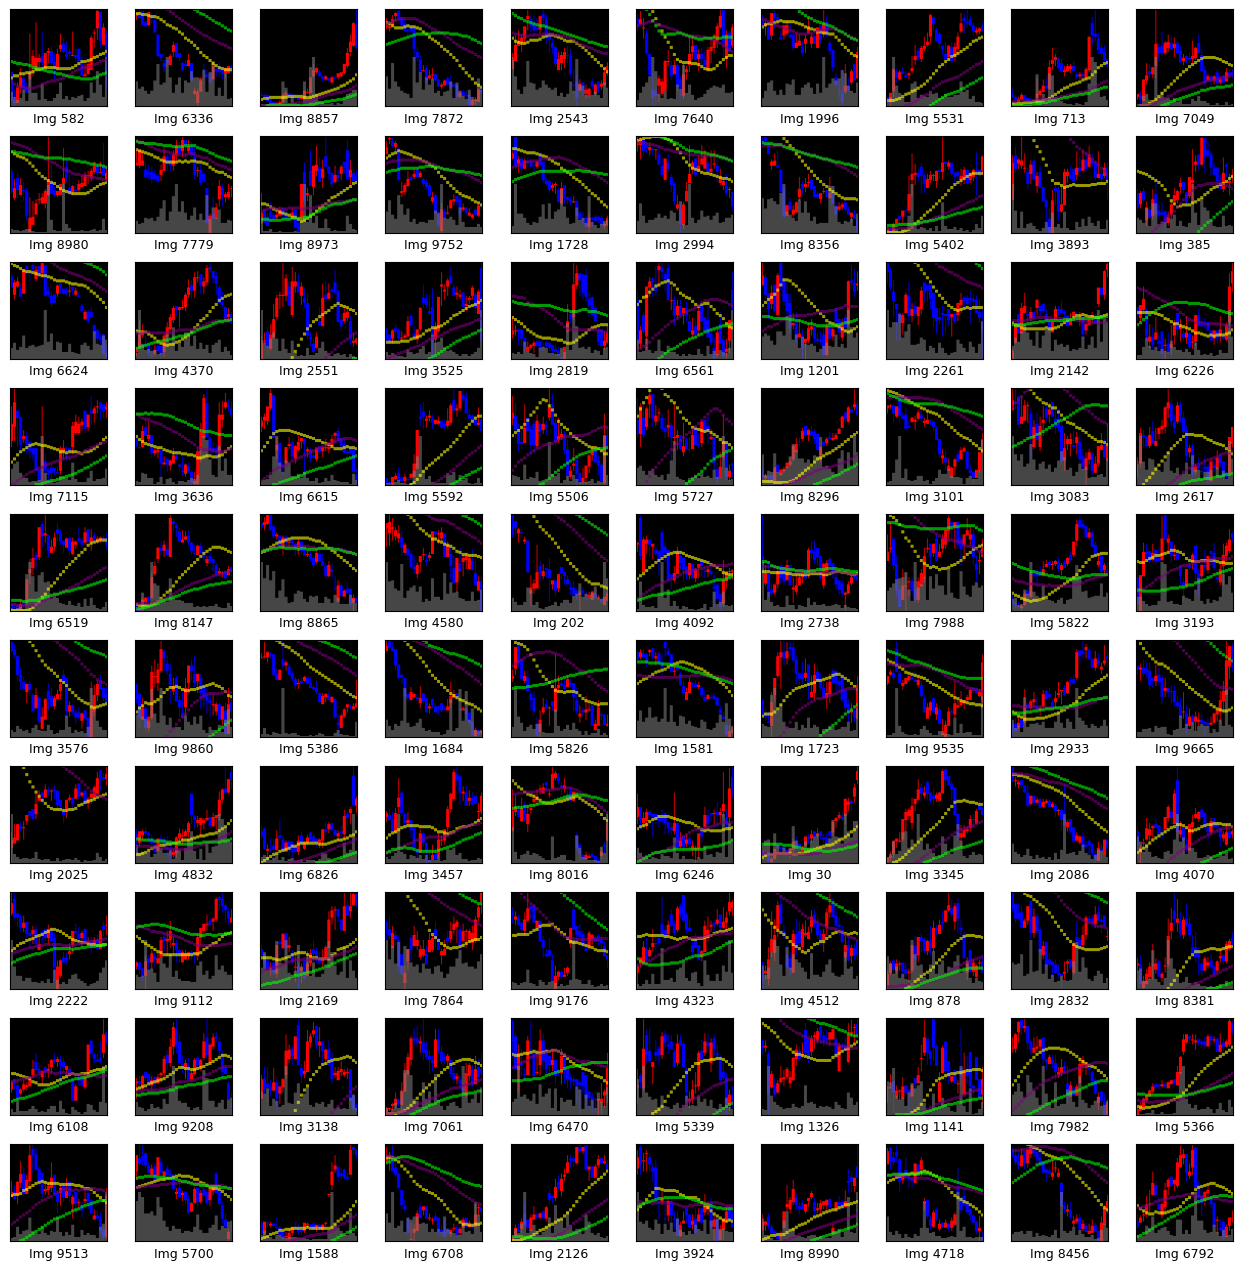

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 이미지 개수와 그리드 크기 설정
num_images = len(train_images)
num_to_display = 100
grid_size = int(np.sqrt(num_to_display))

# 랜덤으로 이미지 인덱스 선택
random_indices = np.random.choice(num_images, num_to_display, replace=False)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
for i in range(grid_size):
    for j in range(grid_size):
        img_idx = random_indices[i * grid_size + j]
        img = Image.fromarray(train_images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel(f'Img {img_idx + 1}', fontsize=9)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

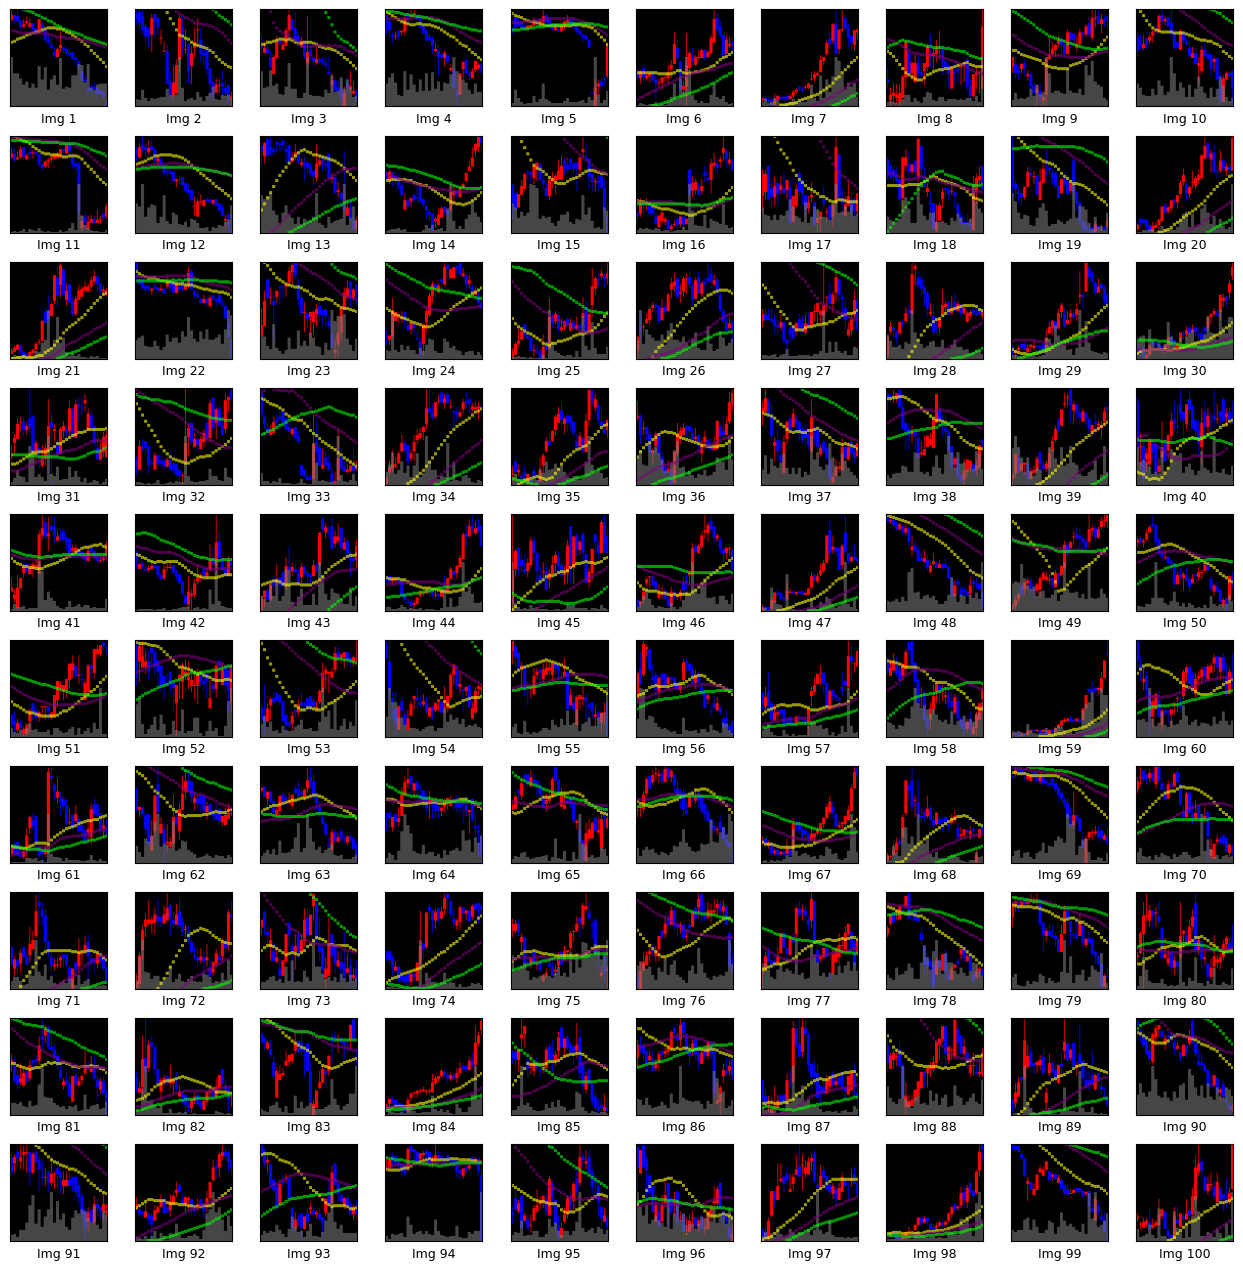

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(16, 16))
for i in range(10):
    for j in range(10):
        img_idx = i * 10 + j
        img = Image.fromarray(train_images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel(f'Img {img_idx + 1}', fontsize=9)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()
